# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
from time import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.metrics import accuracy_score, average_precision_score, fbeta_score, f1_score, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import aequitas as ae
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
from student_utils import *
from utils import *
pd.set_option('display.max_columns', 500)
%matplotlib inline
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## 1. Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

# make exact copy of df to be used later
df_copy = df.copy()

# replace "?" with NaN, and "?|?" with NaN
df = df.replace('?', np.nan).replace("?|?", np.nan)

In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,250.83,NaN,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [5]:
df.shape

(143424, 26)

In [6]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
primary_diagnosis_code      object
other_diagnosis_codes       object
number_outpatient            int64
number_inpatient             int64
number_emergency             int64
num_lab_procedures           int64
number_diagnoses             int64
num_medications              int64
num_procedures               int64
ndc_code                    object
max_glu_serum               object
A1Cresult                   object
change                      object
readmitted                  object
dtype: object

#### Find the Number of Unique Encounters

In [7]:

df['encounter_id'].nunique() 

101766

#### Find the total number of rows of df

In [8]:

len(df)

143424

##### Find the total number of columns of df

In [9]:

df.columns, df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143424 entries, 0 to 143423
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              143424 non-null  int64 
 1   patient_nbr               143424 non-null  int64 
 2   race                      140115 non-null  object
 3   gender                    143424 non-null  object
 4   age                       143424 non-null  object
 5   weight                    4302 non-null    object
 6   admission_type_id         143424 non-null  int64 
 7   discharge_disposition_id  143424 non-null  int64 
 8   admission_source_id       143424 non-null  int64 
 9   time_in_hospital          143424 non-null  int64 
 10  payer_code                89234 non-null   object
 11  medical_specialty         73961 non-null   object
 12  primary_diagnosis_code    143391 non-null  object
 13  other_diagnosis_codes     143084 non-null  object
 14  numb

(Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
        'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
        'time_in_hospital', 'payer_code', 'medical_specialty',
        'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient',
        'number_inpatient', 'number_emergency', 'num_lab_procedures',
        'number_diagnoses', 'num_medications', 'num_procedures', 'ndc_code',
        'max_glu_serum', 'A1Cresult', 'change', 'readmitted'],
       dtype='object'),
 None)

####  Determine Level of Dataset (Line or Encounter)

In [10]:
df.encounter_id.nunique(), df.patient_nbr.nunique()

(101766, 71518)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

Student Response:??
#### The dataset is at the line level because the number of rows is greater than the number of unique encounters


## 2. Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

In [11]:
# Look at range of values & key stats for numerical columns
numerical_feature_list = ['time_in_hospital',  'number_outpatient', 'number_inpatient', 'number_emergency', 'num_lab_procedures', 'number_diagnoses', 'num_medications', 'num_procedures' ]
df[numerical_feature_list].describe()

,time_in_hospital,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures
count,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000
mean,4.490190,0.362429,0.600855,0.195086,43.255745,7.424434,16.776035,1.349021
std,2.999667,1.249295,1.207934,0.920410,19.657319,1.924872,8.397130,1.719104
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,32.000000,6.000000,11.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000,44.000000,8.000000,15.000000,1.000000
75%,6.000000,0.000000,1.000000,0.000000,57.000000,9.000000,21.000000,2.000000
max,14.000000,42.000000,21.000000,76.000000,132.000000,16.000000,81.000000,6.000000


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faa2a34e8d0>,
      dtype=object)

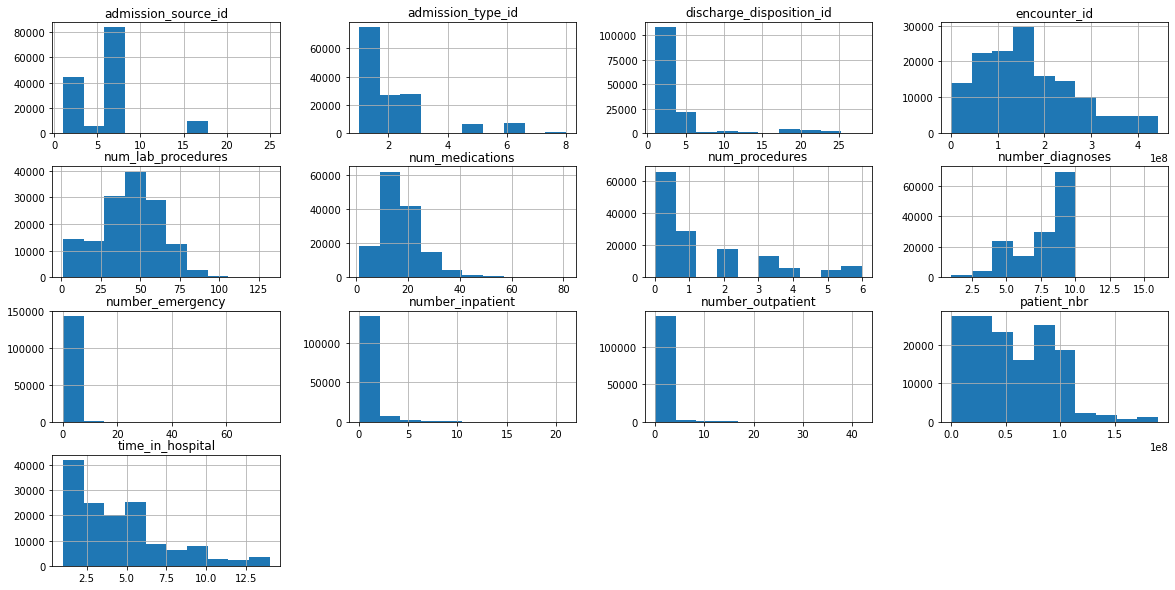

In [12]:
# Plot histograms to show distributions for numerical fields
df.hist(figsize=(20,10))

###### Function to find missing and zero values 

In [13]:

def check_null_values(df):
    null_df = pd.DataFrame({'columns': df.columns, 
                            'percent_null': df.isnull().sum() * 100 / len(df), 
                           'percent_zero': df.isin([0]).sum() * 100 / len(df)
                           } )
    return null_df 

#####  The amount of null values in each column

In [14]:

df.isnull().sum()

encounter_id                     0
patient_nbr                      0
race                          3309
gender                           0
age                              0
weight                      139122
admission_type_id                0
discharge_disposition_id         0
admission_source_id              0
time_in_hospital                 0
payer_code                   54190
medical_specialty            69463
primary_diagnosis_code          33
other_diagnosis_codes          340
number_outpatient                0
number_inpatient                 0
number_emergency                 0
num_lab_procedures               0
number_diagnoses                 0
num_medications                  0
num_procedures                   0
ndc_code                     23462
max_glu_serum                    0
A1Cresult                        0
change                           0
readmitted                       0
dtype: int64

The fields with the highest missing values are weight, payer_code, medical_specialty, and ndc_code. On the other hand fields with the hightest zero values are number_outpatient, number_inpatient, number_emergency, and number_precedures.

###### Missing and zero values and record them in null_df

In [15]:

null_df = check_null_values(df)
null_df

,columns,percent_null,percent_zero
encounter_id,encounter_id,0.000000,0.000000
patient_nbr,patient_nbr,0.000000,0.000000
race,race,2.307145,0.000000
gender,gender,0.000000,0.000000
age,age,0.000000,0.000000
weight,weight,97.000502,0.000000
admission_type_id,admission_type_id,0.000000,0.000000
discharge_disposition_id,discharge_disposition_id,0.000000,0.000000
admission_source_id,admission_source_id,0.000000,0.000000
time_in_hospital,time_in_hospital,0.000000,0.000000


In [16]:
# Here we include age and gender since they are divided into bins

categorical_fields = ['age', 'weight', 'race', 'gender', 'admission_type_id', 'discharge_disposition_id', 
                      'admission_source_id', 'payer_code', 'medical_specialty',
                      'primary_diagnosis_code', 'other_diagnosis_codes', 'ndc_code',
                      'max_glu_serum', 'A1Cresult', 'change', 'readmitted']

In [17]:
# Function to count unique value for each column
def count_unique_values(df, cat_col_list):
    cat_df = df[cat_col_list]
    val_df = pd.DataFrame({'columns': cat_df.columns, 
                       'cardinality': cat_df.nunique() } )
    return val_df

In [18]:
# count unique value for each column and record them in val_df
val_df = count_unique_values(df, categorical_fields) 
val_df

,columns,cardinality
age,age,10
weight,weight,9
race,race,5
gender,gender,3
admission_type_id,admission_type_id,8
discharge_disposition_id,discharge_disposition_id,26
admission_source_id,admission_source_id,17
payer_code,payer_code,17
medical_specialty,medical_specialty,72
primary_diagnosis_code,primary_diagnosis_code,716


The categorical features which has extremely high cardinality (>70) are medical_specialty, primary_diagnosis_code, other_diagnosis_code, and ndc_code. These features have high cardinality since their values represent codes which are plenty in medical field.

**Student Response**: ??

The categorical features which has extremely high cardinality (>70) are medical_specialty, primary_diagnosis_code, other_diagnosis_code, and ndc_code. These features have high cardinality since their values represent codes which are plenty in medical field.

#### Remove columns with high null percentage

In [19]:
df = df.drop(columns = ['weight', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult'])


##### Identify categorical columns

In [20]:
cat_col = list(df.select_dtypes(['object']).columns)
cat_col.extend(['admission_type_id','discharge_disposition_id', 'admission_source_id'])
for col in cat_col:
    df[col] = df[col].astype(str)

#### High cardinality columns 

In [21]:
cat_df = df[cat_col]
cardinality_df = pd.DataFrame({'columns': cat_df.columns, 'cardinality': cat_df.nunique() } )
cardinality_df.sort_values('cardinality', ascending=False)

,columns,cardinality
other_diagnosis_codes,other_diagnosis_codes,19374
primary_diagnosis_code,primary_diagnosis_code,717
ndc_code,ndc_code,252
discharge_disposition_id,discharge_disposition_id,26
admission_source_id,admission_source_id,17
age,age,10
admission_type_id,admission_type_id,8
race,race,6
gender,gender,3
readmitted,readmitted,3


#### High cardinality columns include 'other_diagnosis_codes', 'primary_diagnosis_code', 'ndc_code'


##### Age distribution

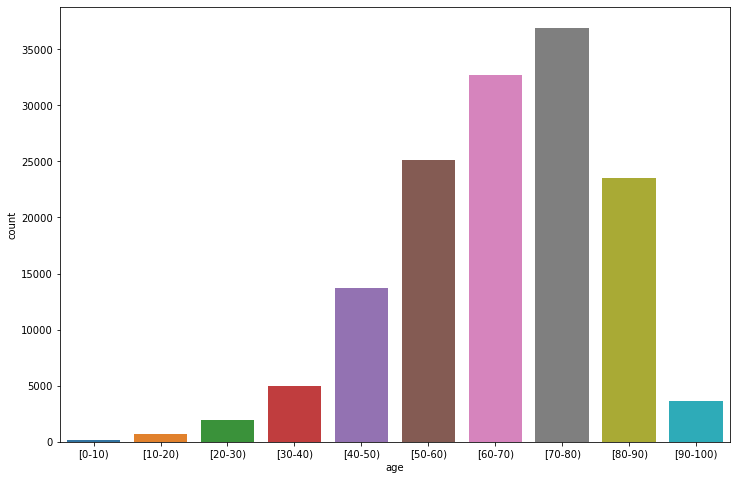

In [22]:
plt.figure(figsize=(12, 8))
sns.countplot(x='age', data=df); 

##### Gender Distribution

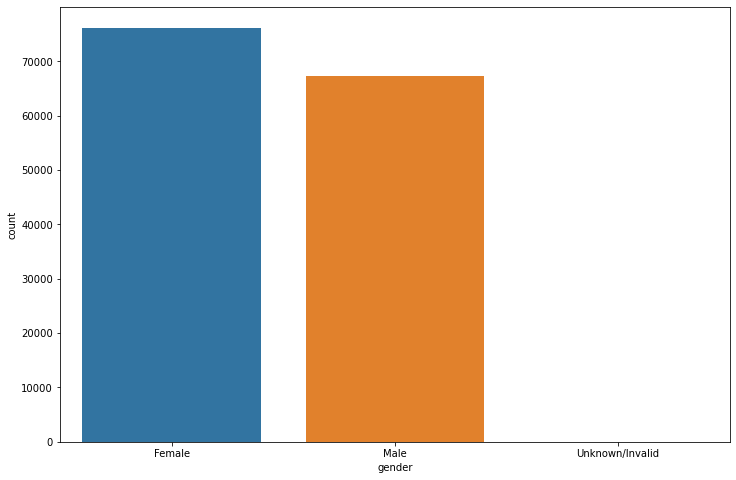

In [23]:
plt.figure(figsize=(12, 8))
sns.countplot(x='gender', data=df); 

In [24]:

len(df[df["gender"] == "Unknown/Invalid"])/len(df["gender"])*100

0.0034861668897813477

#### The percentage of Unknown/Invalid gender 0.0034861668897813477

Student Response:

a. Fields with the highest missing values are __weight, payer_code, medical_specialty, and ndc_code. On the other hand fields with the hightest zero values are number_outpatient, number_inpatient, number_emergency, number_precedures.
b. It seems that 'num_lab_procedures' and 'num_medications' are the numberical features which has gausian or normal distribution.
c. The categorical features which has extremely high cardinality (>70) are medical_specialty, primary_diagnosis_code, other_diagnosis_code, and ndc_code. These features have high cardinality since their values represent codes which are plenty in medical field. 
d. The age distribution is left skewed with the highest peak at age 70 to 80. On the other hand, the gender distribution seems to be uniform with a slight preference toward Female. If we plot both age and gender distribution together, we see that there is a little preference toward male age age 40 to 50, 50 to 60, and 60 to 70. 

##### Distribution of age and gender

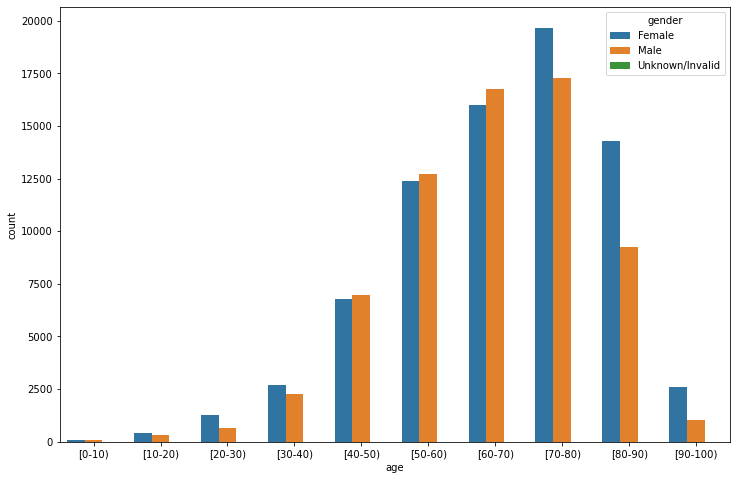

In [25]:
# distribution of age and gender
plt.figure(figsize=(12, 8))
sns.countplot(x="age", hue="gender", data=df); 

##### Time in hospital per race

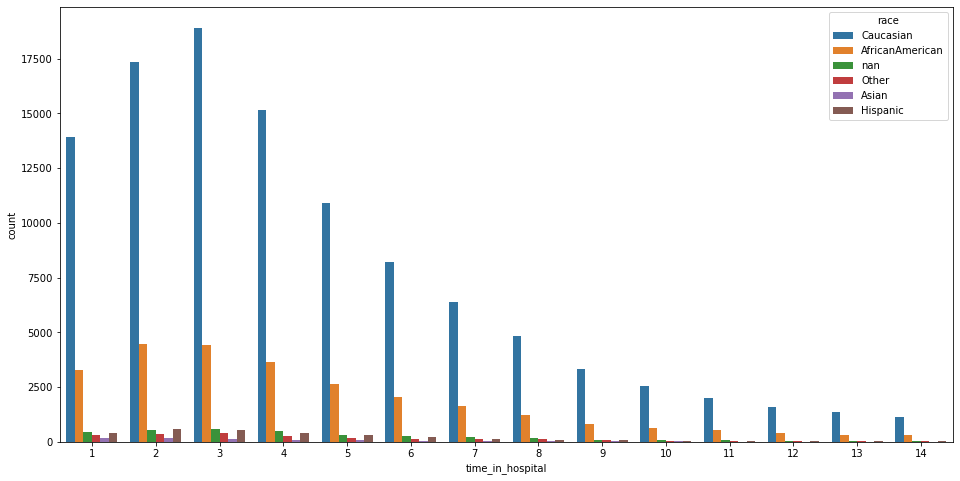

In [26]:
plt.figure(figsize=(16,8))
sns.countplot(x="time_in_hospital", hue="race", data=df)

We see the majority of the patients in the dataset is Caucasian, followed by African American, Hispanic, Other, and Asian.



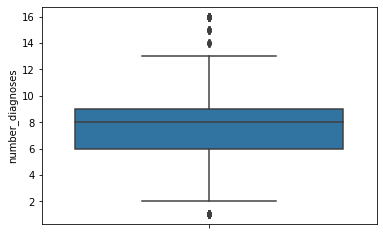

In [27]:
sns.boxplot(y = df['number_diagnoses'])

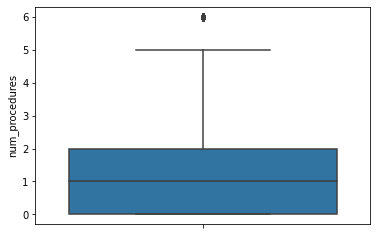

In [28]:
sns.boxplot(y = df['num_procedures'])

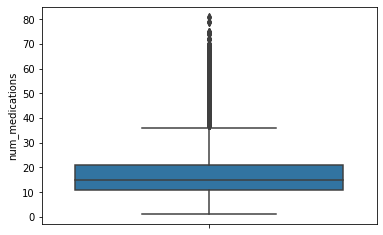

In [29]:
sns.boxplot(y = df['num_medications'])

We see that there are a lot of outliers in num_medication.

In [30]:
df.select_dtypes(['int64']).columns

Index(['encounter_id', 'patient_nbr', 'time_in_hospital', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures'],
      dtype='object')

In [31]:
df[['number_outpatient','number_inpatient']].describe()

,number_outpatient,number_inpatient
count,143424.000000,143424.000000
mean,0.362429,0.600855
std,1.249295,1.207934
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,1.000000
max,42.000000,21.000000


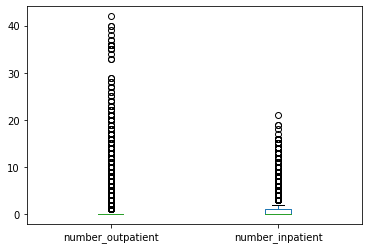

In [32]:
df[['number_outpatient','number_inpatient']].plot(kind='box')

##### There are alot of outliers with on the number of out patient and the number of inpantient

In [33]:
num_col = ['time_in_hospital', 
           'number_outpatient',
           'number_inpatient', 
           'number_emergency', 
           'num_lab_procedures',
           'number_diagnoses', 
           'num_medications', 
           'num_procedures']
df[num_col].describe()

,time_in_hospital,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures
count,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000
mean,4.490190,0.362429,0.600855,0.195086,43.255745,7.424434,16.776035,1.349021
std,2.999667,1.249295,1.207934,0.920410,19.657319,1.924872,8.397130,1.719104
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,32.000000,6.000000,11.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000,44.000000,8.000000,15.000000,1.000000
75%,6.000000,0.000000,1.000000,0.000000,57.000000,9.000000,21.000000,2.000000
max,14.000000,42.000000,21.000000,76.000000,132.000000,16.000000,81.000000,6.000000


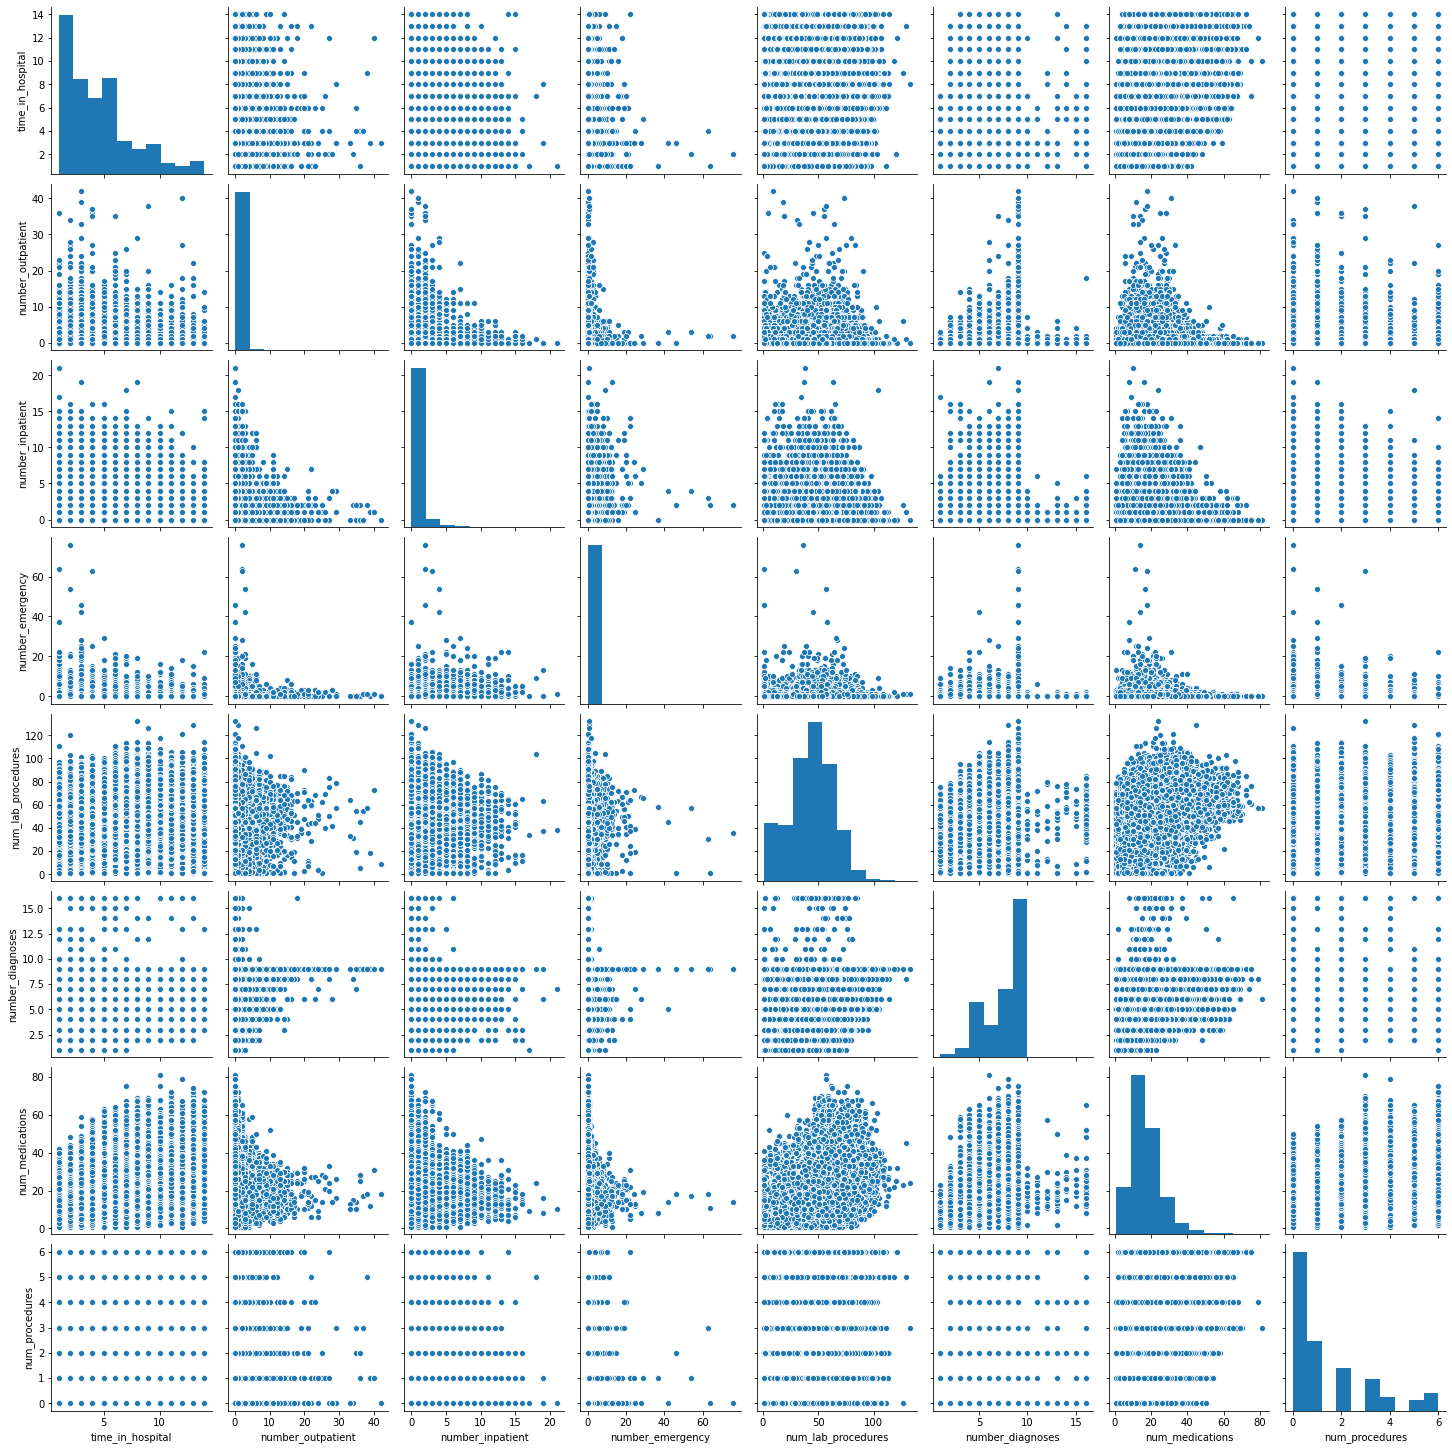

In [34]:
sns.pairplot(df[num_col]);

#### From the pairplot num_medications and num_lab_procecures follows normal distribution

In [35]:
df[['number_diagnoses','num_medications']].describe()

,number_diagnoses,num_medications
count,143424.000000,143424.000000
mean,7.424434,16.776035
std,1.924872,8.397130
min,1.000000,1.000000
25%,6.000000,11.000000
50%,8.000000,15.000000
75%,9.000000,21.000000
max,16.000000,81.000000


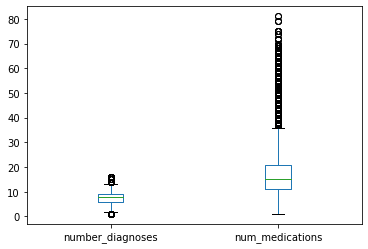

In [36]:
df[['number_diagnoses','num_medications']].plot(kind='box')

##### There are also some good number of outliers when it come to number of medications

In [37]:
# num_medications and num_lab_procecures follows normal distribution
#sns.pairplot(df[num_col]);

In [38]:
df.shape

(143424, 21)

In [39]:
#import tensorflow_data_validation as tfdv


In [40]:
#!pip install apache-beam[interactive]

In [41]:
######NOTE: The visualization will only display in Chrome browser. ########
#full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
#tfdv.visualize_statistics(full_data_stats)

## 3. Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [42]:
# Get the original df back
df = df_copy.copy()

#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)
ndc_code_df.head()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


From above we see that multiple NDC_Code has the same Non-propriatary Name or generic drug name.

In [43]:
ndc_code_df.NDC_Code.nunique()

267

In [44]:
len(ndc_code_df)

269

##### Examining 2 columns Proprietary Name and Non-proprietary Name

In [45]:
ndc_code_df[['Proprietary Name', 'Non-proprietary Name']].describe()

,Proprietary Name,Non-proprietary Name
count,269,269
unique,39,24
top,Metformin Hydrochloride,Metformin Hydrochloride
freq,61,71


#### Examining 2 columns Proprietary Name and Dosage Form 

In [46]:
ndc_code_df[['Proprietary Name','Dosage Form']].describe()

,Proprietary Name,Dosage Form
count,269,267
unique,39,9
top,Metformin Hydrochloride,Tablet
freq,61,159


There are 269 propriatary Names and 267 Dosage Forms, 39 unique Propriatary Names out 267 unique codes and 9 Dosage form. The top Proprietary name is Metformin Hydrochloride and the dosage form is Tablet.

In [47]:

ndc_code_df.isnull().sum()

NDC_Code                0
Proprietary Name        0
Non-proprietary Name    0
Dosage Form             2
Route Name              5
Company Name            2
Product Type            2
dtype: int64

In [48]:
# Check for duplicate NDC_Code's
ndc_code_df[ndc_code_df.duplicated(subset=['NDC_Code'])]

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
263,0781-5634,Pioglitazone Hydrochloride And Glimepiride,Pioglitazone Hydrochloride And Glimepiride,Tablet,Oral,Sandoz Inc,Human Prescription Drug
264,0781-5635,Pioglitazone Hydrochloride And Glimepiride,Pioglitazone Hydrochloride And Glimepiride,Tablet,Oral,Sandoz Inc,Human Prescription Drug


In [49]:
# Remove duplicates
ndc_code_df = ndc_code_df.drop(ndc_code_df.index[[263,264]])
ndc_code_df[ndc_code_df.duplicated(subset=['NDC_Code'])]

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type


In [50]:
len(ndc_code_df)

267

In [51]:
# Create reduce_dim_df from df which map the ndc_code in df to Non-proprietary Name in ndc_code_df
# We change the Non-proprietary Name to generic_drug_name, then delete the column ndc_code

reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)
reduce_dim_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,None,None,No,NO,NaN
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,None,None,Ch,>30,Human Insulin
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,None,None,No,NO,Glipizide
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,None,None,Ch,NO,Human Insulin
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,None,None,Ch,NO,Glipizide


In [52]:
# Check the patient number of the merged dataset
reduce_dim_df['patient_nbr'].nunique()

71518

###### Find the number of null value in ndc_code_df

###### Number of unique values should be less for the new output field

In [53]:
# Check the shape of the merged dataset
reduce_dim_df.shape

(143424, 26)

In [54]:
# Make sure the lenght of reduce_dim_df is equal to len of df
len(reduce_dim_df)==len(df)

True

In [55]:

# Find the number of unique 'generic_drug_name' of reduce_dim_df
reduce_dim_df['generic_drug_name'].nunique()

22

In [56]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()
print("Successfully Reduce Dimensionality of the NDC Code Feature")

Successfully Reduce Dimensionality of the NDC Code Feature


## 4. Select First Encounter for each Patient

In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [57]:
first_encounter_df = select_first_encounter(reduce_dim_df)
first_encounter_df.head()

,patient_nbr,encounter_id,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
0,135,24437208,Caucasian,Female,[50-60),?,2,1,1,8,?,Cardiology,401,997|560,0,0,0,77,8,33,6,None,None,Ch,<30,Metformin Hydrochloride
1,378,29758806,Caucasian,Female,[50-60),?,3,1,1,2,?,Surgery-Neuro,722,305|250,0,0,0,49,3,11,1,None,None,No,NO,NaN
2,729,189899286,Caucasian,Female,[80-90),?,1,3,7,4,MC,InternalMedicine,820,493|E880,0,0,0,68,9,23,2,None,>7,No,NO,Metformin Hydrochloride
3,774,64331490,Caucasian,Female,[80-90),?,1,1,7,3,?,InternalMedicine,274,427|416,0,0,0,46,9,20,0,None,>8,Ch,NO,Metformin Hydrochloride
4,927,14824206,AfricanAmerican,Female,[30-40),?,1,1,7,5,?,InternalMedicine,590,220|250,0,0,0,49,3,5,0,None,None,No,NO,Glimepiride


In [58]:
first_encounter_df.shape

(71518, 26)

In [59]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


### 5. Aggregate Dataset to Right Level for Modeling

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [60]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]

In [61]:
from utils import aggregate_dataset
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

/home/workspace/starter_code/utils.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={


In [62]:
agg_drug_df.head()

,patient_nbr,encounter_id,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,135,24437208,Caucasian,Female,[50-60),?,2,1,1,8,?,Cardiology,401,997|560,0,0,0,77,8,33,6,None,None,Ch,<30,[Metformin Hydrochloride],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,378,29758806,Caucasian,Female,[50-60),?,3,1,1,2,?,Surgery-Neuro,722,305|250,0,0,0,49,3,11,1,None,None,No,NO,[nan],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,729,189899286,Caucasian,Female,[80-90),?,1,3,7,4,MC,InternalMedicine,820,493|E880,0,0,0,68,9,23,2,None,>7,No,NO,[Metformin Hydrochloride],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,774,64331490,Caucasian,Female,[80-90),?,1,1,7,3,?,InternalMedicine,274,427|416,0,0,0,46,9,20,0,None,>8,Ch,NO,[Metformin Hydrochloride],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,927,14824206,AfricanAmerican,Female,[30-40),?,1,1,7,5,?,InternalMedicine,590,220|250,0,0,0,49,3,5,0,None,None,No,NO,[Glimepiride],0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
first_encounter_df.generic_drug_name.unique()

array(['Metformin Hydrochloride', nan, 'Glimepiride', 'Insulin Human',
       'Human Insulin', 'Glipizide', 'Rosiglitazone Maleate', 'Glyburide',
       'Repaglinide', 'Pioglitazone',
       'Pioglitazone Hydrochloride And Glimepiride', 'Metformin Hcl',
       'Nateglinide', 'Tolbutamide',
       'Glyburide And Metformin Hydrochloride', 'Acarbose',
       'Glyburide-metformin Hydrochloride', 'Tolazamide', 'Miglitol',
       'Glipizide And Metformin Hcl',
       'Glipizide And Metformin Hydrochloride'], dtype=object)

In [64]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()
print("Succesfully Aggregate Dataset to Right Level for Modeling")

Succesfully Aggregate Dataset to Right Level for Modeling


In [65]:
agg_drug_df=agg_drug_df.replace('?',np.nan).replace('?|?',np.nan)
agg_drug_df.head()

,patient_nbr,encounter_id,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,135,24437208,Caucasian,Female,[50-60),NaN,2,1,1,8,NaN,Cardiology,401,997|560,0,0,0,77,8,33,6,None,None,Ch,<30,[Metformin Hydrochloride],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,378,29758806,Caucasian,Female,[50-60),NaN,3,1,1,2,NaN,Surgery-Neuro,722,305|250,0,0,0,49,3,11,1,None,None,No,NO,[nan],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,729,189899286,Caucasian,Female,[80-90),NaN,1,3,7,4,MC,InternalMedicine,820,493|E880,0,0,0,68,9,23,2,None,>7,No,NO,[Metformin Hydrochloride],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,774,64331490,Caucasian,Female,[80-90),NaN,1,1,7,3,NaN,InternalMedicine,274,427|416,0,0,0,46,9,20,0,None,>8,Ch,NO,[Metformin Hydrochloride],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,927,14824206,AfricanAmerican,Female,[30-40),NaN,1,1,7,5,NaN,InternalMedicine,590,220|250,0,0,0,49,3,5,0,None,None,No,NO,[Glimepiride],0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 6.  Prepare Fields and Cast Dataset

### Feature Selection

**Question 5:** After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset.

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

In [66]:
(agg_drug_df.isnull().sum()/len(agg_drug_df))*100

patient_nbr                                    0.000000
encounter_id                                   0.000000
race                                           2.723790
gender                                         0.000000
age                                            0.000000
weight                                        96.010794
admission_type_id                              0.000000
discharge_disposition_id                       0.000000
admission_source_id                            0.000000
time_in_hospital                               0.000000
payer_code                                    43.405856
medical_specialty                             48.207444
primary_diagnosis_code                         0.015381
other_diagnosis_codes                          0.341173
number_outpatient                              0.000000
number_inpatient                               0.000000
number_emergency                               0.000000
num_lab_procedures                             0

In [67]:
(agg_drug_df.isnull().sum()/len(agg_drug_df))*100

patient_nbr                                    0.000000
encounter_id                                   0.000000
race                                           2.723790
gender                                         0.000000
age                                            0.000000
weight                                        96.010794
admission_type_id                              0.000000
discharge_disposition_id                       0.000000
admission_source_id                            0.000000
time_in_hospital                               0.000000
payer_code                                    43.405856
medical_specialty                             48.207444
primary_diagnosis_code                         0.015381
other_diagnosis_codes                          0.341173
number_outpatient                              0.000000
number_inpatient                               0.000000
number_emergency                               0.000000
num_lab_procedures                             0

Student response:

* weight, payer_code, and medical_specialty have extremely high null values. Those column will be excluded in the model.



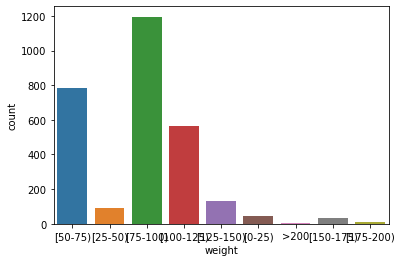

In [68]:
# Look at counts for weight categories
ax = sns.countplot(x="weight", data=agg_drug_df)

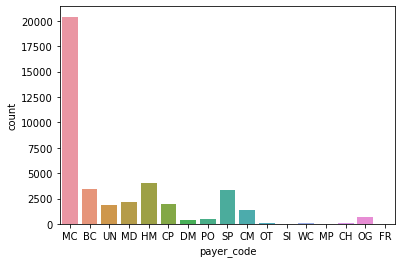

In [69]:
# Look at counts for payer_code categories
ax = sns.countplot(x="payer_code", data=agg_drug_df)

In [70]:
# Find the cardinality of other_diagnosis_codes
agg_drug_df["other_diagnosis_codes"].nunique()

15755

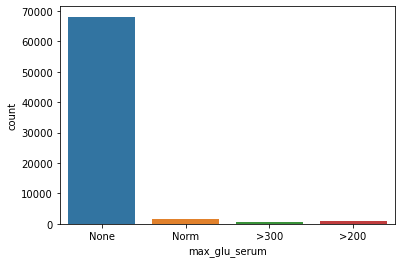

In [71]:
sns.countplot(agg_drug_df["max_glu_serum"])

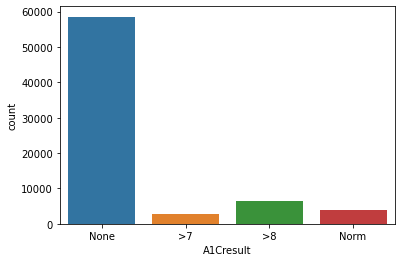

In [72]:
sns.countplot(agg_drug_df['A1Cresult'])

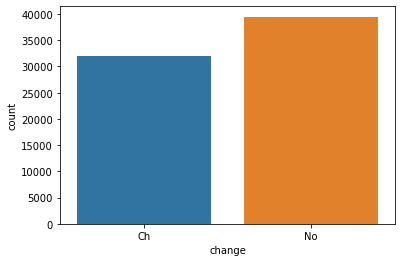

In [73]:
sns.countplot(agg_drug_df['change'])

In [74]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']
student_categorical_col_list = ["primary_diagnosis_code", "readmitted", "A1Cresult"] + required_demo_col_list + ndc_col_list
student_numerical_col_list = ["num_lab_procedures", "num_medications"]
PREDICTOR_FIELD = 'time_in_hospital'

In [75]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]

In [76]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)

In [77]:
selected_features_df.head() 

,patient_nbr,time_in_hospital,primary_diagnosis_code,readmitted,A1Cresult,race,gender,age,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,num_lab_procedures,num_medications
0,135,8,401,<30,None,Caucasian,Female,[50-60),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77,33
1,378,2,722,NO,None,Caucasian,Female,[50-60),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49,11
2,729,4,820,NO,>7,Caucasian,Female,[80-90),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68,23
3,774,3,274,NO,>8,Caucasian,Female,[80-90),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46,20
4,927,5,590,NO,None,AfricanAmerican,Female,[30-40),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49,5


In [78]:
selected_features_df.shape

(71518, 30)

### Preprocess Dataset - Casting and Imputing


Preprocess Dataset - Casting and Imputing
We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features.

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

In [79]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

/home/workspace/starter_code/utils.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = df[predictor].astype(float)
/home/workspace/starter_code/utils.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/home/workspace/starter_code/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [80]:
processed_df.head()

,patient_nbr,time_in_hospital,primary_diagnosis_code,readmitted,A1Cresult,race,gender,age,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,num_lab_procedures,num_medications
0,135,8.0,401,<30,None,Caucasian,Female,[50-60),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77,33
1,378,2.0,722,NO,None,Caucasian,Female,[50-60),nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,49,11
2,729,4.0,820,NO,>7,Caucasian,Female,[80-90),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68,23
3,774,3.0,274,NO,>8,Caucasian,Female,[80-90),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46,20
4,927,5.0,590,NO,None,AfricanAmerican,Female,[30-40),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49,5


In [81]:
processed_df.shape

(71518, 30)

In [82]:
# Check the percentage of null values for each column in processed_df
processed_df.isnull().sum()/len(processed_df)*100

patient_nbr                                   0.0
time_in_hospital                              0.0
primary_diagnosis_code                        0.0
readmitted                                    0.0
A1Cresult                                     0.0
race                                          0.0
gender                                        0.0
age                                           0.0
Acarbose                                      0.0
Glimepiride                                   0.0
Glipizide                                     0.0
Glipizide_And_Metformin_Hcl                   0.0
Glipizide_And_Metformin_Hydrochloride         0.0
Glyburide                                     0.0
Glyburide_And_Metformin_Hydrochloride         0.0
Glyburide-metformin_Hydrochloride             0.0
Human_Insulin                                 0.0
Insulin_Human                                 0.0
Metformin_Hcl                                 0.0
Metformin_Hydrochloride                       0.0


In [83]:
processed_df.describe()

,patient_nbr,time_in_hospital,num_lab_procedures,num_medications
count,7.151800e+04,71518.00000,71518.000000,71518.000000
mean,5.505160e+07,4.28913,43.075478,15.705025
std,3.947573e+07,2.94921,19.952338,8.311163
min,1.350000e+02,1.00000,1.000000,1.000000
25%,2.337577e+07,2.00000,31.000000,10.000000
50%,4.816680e+07,3.00000,44.000000,14.000000
75%,8.752222e+07,6.00000,57.000000,20.000000
max,1.895026e+08,14.00000,132.000000,81.000000


## 7.  Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [84]:
from student_utils import patient_dataset_splitter

# Split the processed_df into 80% train set and 20% test set
d_train, d_test = patient_dataset_splitter(processed_df, 'patient_nbr', 0.2)

print("Temporary train shape: ",d_train.shape)
print("Final test shape: ",d_test.shape )

Temporary train shape:  (57214, 30)
Final test shape:  (14304, 30)


In [85]:
# Split the d_train into 75% train set and 25% val set. By doing so, we will get 60%/20%/20% of
# d_train, d_test, d_val from processed_df
d_train, d_val = patient_dataset_splitter(d_train, 'patient_nbr', 0.25)

print("Final train shape: ",d_train.shape)
print("Final validation shape: ",d_val.shape )

Final train shape:  (42910, 30)
Final validation shape:  (14304, 30)


In [86]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [87]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## 8. Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0     10717
2.0     12397
3.0     12701
4.0      9567
5.0      6839
6.0      5171
7.0      3999
8.0      2919
9.0      1990
10.0     1558
11.0     1241
12.0      955
13.0      795
14.0      669
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


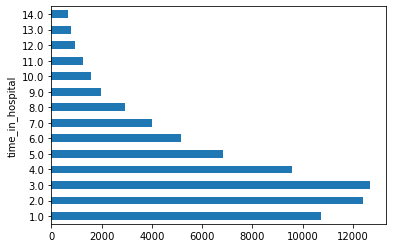

In [88]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     6419
2.0     7489
3.0     7576
4.0     5773
5.0     4056
6.0     3093
7.0     2364
8.0     1777
9.0     1183
10.0     961
11.0     765
12.0     578
13.0     495
14.0     381
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


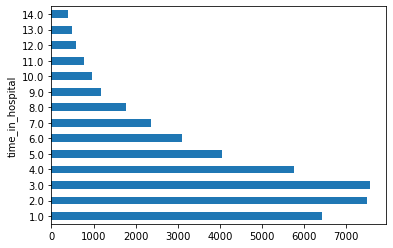

In [89]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     2159
2.0     2411
3.0     2556
4.0     1875
5.0     1389
6.0     1097
7.0      807
8.0      563
9.0      396
10.0     307
11.0     249
12.0     191
13.0     150
14.0     154
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


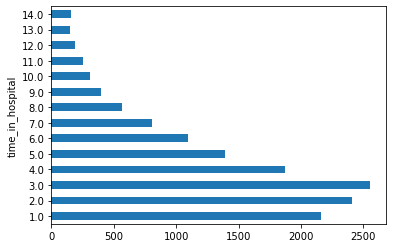

In [90]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female             38025
Male               33490
Unknown/Invalid        3
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


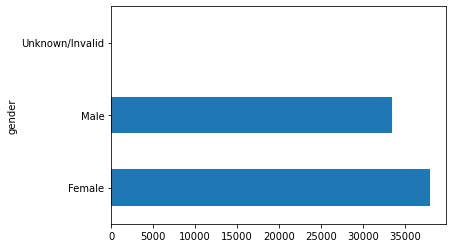

In [91]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female             22811
Male               20097
Unknown/Invalid        2
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


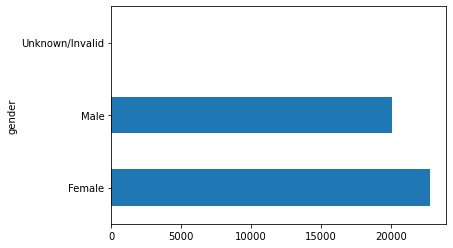

In [92]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female    7553
Male      6751
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


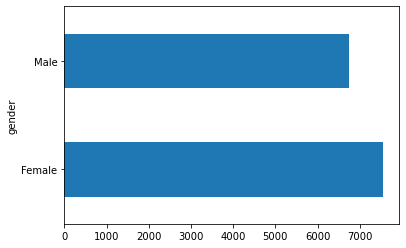

In [93]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Race Group Analysis

race
AfricanAmerican    12887
Asian                497
Caucasian          53491
Hispanic            1517
Other               1178
nan                 1948
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


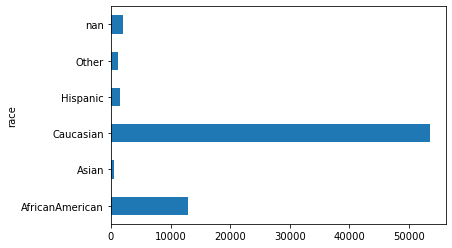

In [94]:
show_group_stats_viz(patient_group_analysis_df, 'race')

race
AfricanAmerican     7783
Asian                302
Caucasian          31989
Hispanic             928
Other                735
nan                 1173
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


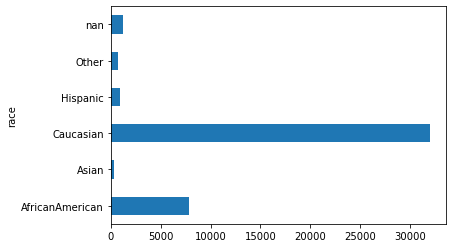

In [95]:
show_group_stats_viz(d_train, 'race')

race
AfricanAmerican     2580
Asian                100
Caucasian          10660
Hispanic             304
Other                238
nan                  422
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


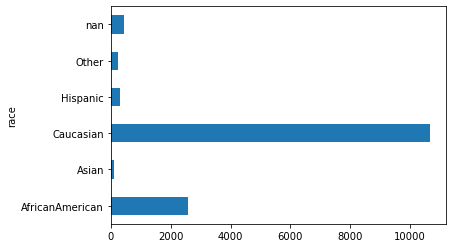

In [96]:
show_group_stats_viz(d_test, 'race')

race
AfricanAmerican     2524
Asian                 95
Caucasian          10842
Hispanic             285
Other                205
nan                  353
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


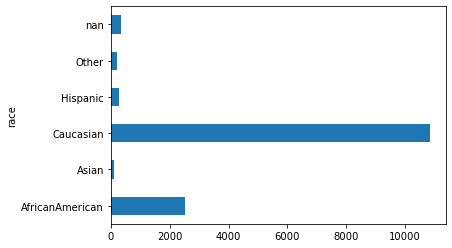

In [97]:
show_group_stats_viz(d_val, 'race')

Age Group Analysis

age
[0-10)        154
[10-20)       535
[20-30)      1127
[30-40)      2699
[40-50)      6878
[50-60)     12466
[60-70)     15960
[70-80)     18210
[80-90)     11589
[90-100)     1900
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


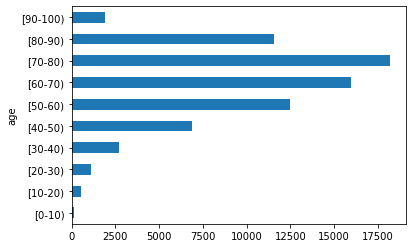

In [98]:
show_group_stats_viz(patient_group_analysis_df, 'age')

age
[0-10)         90
[10-20)       323
[20-30)       684
[30-40)      1598
[40-50)      4148
[50-60)      7583
[60-70)      9614
[70-80)     10897
[80-90)      6839
[90-100)     1134
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


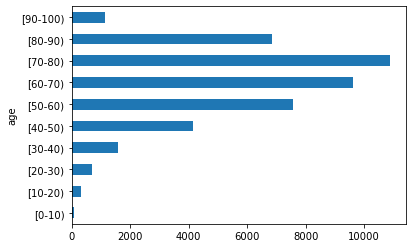

In [99]:
show_group_stats_viz(d_train, 'age')

age
[0-10)        27
[10-20)      102
[20-30)      227
[30-40)      547
[40-50)     1389
[50-60)     2433
[60-70)     3149
[70-80)     3663
[80-90)     2391
[90-100)     376
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


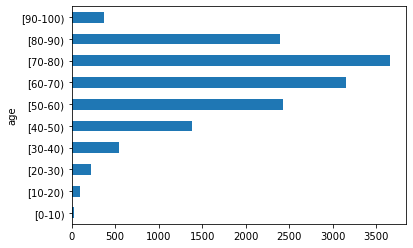

In [100]:
show_group_stats_viz(d_test, 'age')

age
[0-10)        37
[10-20)      110
[20-30)      216
[30-40)      554
[40-50)     1341
[50-60)     2450
[60-70)     3197
[70-80)     3650
[80-90)     2359
[90-100)     390
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


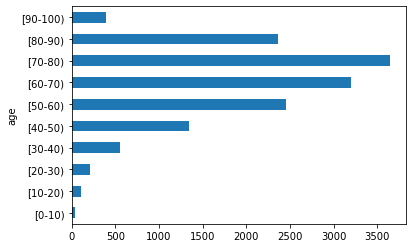

In [101]:
show_group_stats_viz(d_val, 'age')

From the above historgrams, we see that gender, race, and age across our splits have similar distribution shapes across partitions.

## 9. Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [102]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [103]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

## 10.  Create Categorical Features with TF Feature Columns

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. 

##### Build Vocabulary for Categorical Features

In [104]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

In [105]:

vocab_file_list[1]

'./diabetes_vocab/readmitted_vocab.txt'

#### Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [106]:
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

INFO:tensorflow:vocabulary_size = 650 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in readmitted is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/readmitted_vocab.txt.
INFO:tensorflow:vocabulary_size = 5 in A1Cresult is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/A1Cresult_vocab.txt.
INFO:tensorflow:vocabulary_size = 7 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.
INFO:tensorflow:vocabulary_size = 11 in age is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/age_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in Acarbose is inferred from the number of elements in the vo

In [107]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='primary_diagnosis_code', vocabulary_file='./diabetes_vocab/primary_diagnosis_code_vocab.txt', vocabulary_size=650, num_oov_buckets=1, dtype=tf.string, default_value=-1))
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(128, 651), dtype=float32)


#### Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [108]:
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [109]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list


In [110]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)


In [111]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='num_lab_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7faa2c347c20>, mean=43.03418783500349, std=19.962718314452573))

tf.Tensor(
[[ 0.6315789 ]
 [ 1.0526316 ]
 [ 1.8421053 ]
 [ 1.2631578 ]
 [-0.2631579 ]
 [ 1.7894737 ]
 [-0.31578946]
 [ 0.57894737]
 [-0.84210527]
 [-0.36842105]
 [-0.05263158]
 [ 0.42105263]
 [ 0.15789473]
 [ 1.        ]
 [ 0.15789473]
 [ 0.36842105]
 [ 0.36842105]
 [ 1.7368422 ]
 [ 0.2631579 ]
 [-1.7368422 ]
 [-2.        ]
 [ 0.8947368 ]
 [-2.1052632 ]
 [-0.36842105]
 [ 1.4210526 ]
 [ 0.05263158]
 [ 0.2631579 ]
 [ 0.31578946]
 [ 0.31578946]
 [ 0.94736844]
 [ 1.        ]
 [ 0.21052632]
 [-1.1052631 ]
 [ 1.5263158 ]
 [ 1.7368422 ]
 [ 0.68421054]
 [-0.5263158 ]
 [ 1.7368422 ]
 [-2.        ]
 [ 1.        ]
 [-2.1052632 ]
 [ 0.        ]
 [-1.2105263 ]
 [ 0.7894737 ]
 [ 0.05263158]
 [-0.42105263]
 [-0.15789473]
 [ 0.6315789 ]
 [ 0.789473

## 11. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

### Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [112]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

### Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [113]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [114]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds, claim_feature_layer,  epochs=20)


Train for 336 steps, validate for 112 steps
Epoch 1/20
336/336 [==============================] - 13s 38ms/step - loss: 23.8046 - mse: 23.6168 - val_loss: 19.9150 - val_mse: 19.5927
Epoch 2/20
336/336 [==============================] - 9s 27ms/step - loss: 17.7846 - mse: 17.2162 - val_loss: 14.2429 - val_mse: 13.2800
Epoch 3/20
336/336 [==============================] - 9s 27ms/step - loss: 13.0666 - mse: 12.2210 - val_loss: 11.8101 - val_mse: 10.8547
Epoch 4/20
336/336 [==============================] - 9s 27ms/step - loss: 11.8569 - mse: 11.0117 - val_loss: 9.9943 - val_mse: 9.0645
Epoch 5/20
336/336 [==============================] - 9s 27ms/step - loss: 10.8867 - mse: 10.0151 - val_loss: 9.7666 - val_mse: 8.7964
Epoch 6/20
336/336 [==============================] - 9s 27ms/step - loss: 10.2927 - mse: 9.3907 - val_loss: 8.9933 - val_mse: 8.1117
Epoch 7/20
336/336 [==============================] - 9s 27ms/step - loss: 9.7083 - mse: 8.7621 - val_loss: 9.4581 - val_mse: 8.4579
Epoch 8

In [115]:
loss, mse = diabetes_model.evaluate(diabetes_test_ds, verbose=2)

112/112 - 2s - loss: 7.7610 - mse: 6.9492


### Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [116]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [117]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [118]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

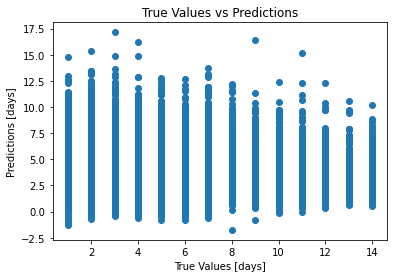

In [119]:
# Plot the True Values vs Predictions
plt.scatter(d_test['time_in_hospital'].values, preds.flatten())
plt.xlabel('True Values [days]')
plt.ylabel('Predictions [days]')
plt.title('True Values vs Predictions')
plt.show()

In [120]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,5.284508,8.0,8.452304,0.706153
1,3.856185,3.0,3.078689,0.703471
2,5.617723,3.0,3.879784,0.702955
3,5.355962,3.0,3.294283,0.703633
4,3.479583,3.0,5.910421,0.705621


In [121]:
prob_output_df.tail()

,pred,actual_value,pred_mean,pred_std
14299,9.331409,6.0,3.926116,0.702316
14300,4.297374,11.0,10.964272,0.710090
14301,11.489820,5.0,5.011972,0.703359
14302,8.058321,1.0,4.195064,0.704475
14303,7.388502,5.0,3.080160,0.703437


In [122]:
prob_output_df.describe()

,pred,actual_value,pred_mean,pred_std
count,14304.000000,14304.000000,14304.000000,14304.000000
mean,3.999840,4.306488,4.404605,0.704019
std,2.122742,2.959353,1.988446,0.001396
min,-1.755421,1.000000,1.254870,0.699269
25%,2.496331,2.000000,2.938357,0.703203
50%,3.659727,4.000000,4.038965,0.703801
75%,5.161924,6.000000,5.525828,0.704556
max,17.153912,14.000000,13.959826,0.713558


### Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [123]:
from student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')
student_binary_prediction 

array([1, 0, 0, ..., 1, 0, 0])

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [124]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [125]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

,patient_nbr,gender,race,time_in_hospital,score,label_value
0,90522675,Female,Caucasian,8.0,1,1
1,53701614,Female,Caucasian,3.0,0,0
2,87878943,Male,Caucasian,3.0,0,0
3,2147274,Female,Caucasian,3.0,0,0
4,23208975,Female,Caucasian,3.0,1,0


## 12. Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [126]:
# AUC, F1, precision and recall
# Summary

In [127]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score 


In [128]:
y_true = pred_test_df['label_value'].values 
y_pred = pred_test_df['score'].values
pred_prob = prob_output_df['pred_mean'].values

In [129]:
accuracy_score(y_true, y_pred)

0.7562220357941835

In [130]:
print("Classification report: \n",classification_report(y_true, y_pred))
print("Accuracy score: ",accuracy_score(y_true, y_pred))
print("F1 score(weighted): ", f1_score(y_true, y_pred, average='weighted'))
print("ROC AUC: ",roc_auc_score(y_true, y_pred))

Classification report: 
               precision    recall  f1-score   support

           0       0.79      0.84      0.81      9001
           1       0.69      0.61      0.65      5303

    accuracy                           0.76     14304
   macro avg       0.74      0.73      0.73     14304
weighted avg       0.75      0.76      0.75     14304

Accuracy score:  0.7562220357941835
F1 score(weighted):  0.7525724042386085
ROC AUC:  0.7263464010944538


Precision-recall tradeoff - The model has been optimised to identify those patients correct for the trial with the fewest mistakes, while also trying to ensure we identify as many of them as possible.


Areas of imporovement - we could look to engineer new features that might help us better predict our target patients.



In [131]:
from sklearn.metrics import precision_score, recall_score
print('Precision: %.3f' % precision_score(y_true, y_pred))
print('Recall: %.3f' % recall_score(y_true, y_pred))

Precision: 0.695
Recall: 0.611


In [132]:
def plot_roc_curve(ground_truth, probability):
    fpr, tpr, thresholds = roc_curve(ground_truth, probability)
    AUC = '%s (AUC:%0.2f)'  % ('Time in Hospital', auc(fpr, tpr))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate (1-Specificity)')
    plt.ylabel('True Positive Rate')
    plt.show()
    print('AUC: ', AUC)

def plot_precision_recall_curve(ground_truth, probability):
    precision, recall, _ = precision_recall_curve(ground_truth, probability)
    AP = '%s (AP Score:%0.2f)'  % ('Time in Hospital', average_precision_score(ground_truth, probability))
    plt.plot(recall, precision, linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    print('AP: ', AP) 

In [133]:
def plot_precision_recall_vs_threshold(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "b--", label="Precision")
    plt.plot(threshold, recall[:-1], "g-", label="Recall")
    plt.legend(["Precision", "Recall"], loc ="center right")
    plt.title('Precision & Recall vs Threshold')
    plt.xlabel('Threshold')
    plt.show

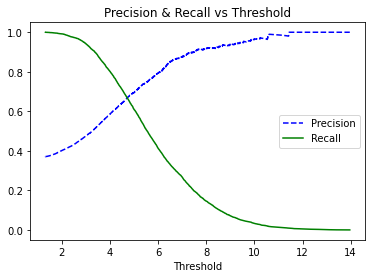

In [134]:
precision, recall, threshold = precision_recall_curve(y_true,pred_prob)

plot_precision_recall_vs_threshold(precision, recall, threshold)

We see that the threshold of 6 is indeed give us the best precision and recall score.



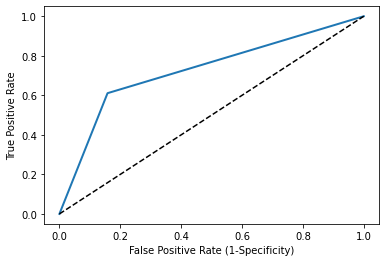

AUC:  Time in Hospital (AUC:0.73)


In [135]:
plot_roc_curve(y_true,y_pred)


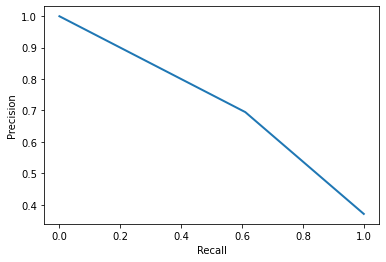

AP:  Time in Hospital (AP Score:0.57)


In [136]:
plot_precision_recall_curve(y_true,y_pred)

### 13. Evaluating Potential Model Biases with Aequitas Toolkit

#### Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [137]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


model_id, score_thresholds 1 {'rank_abs': [4662]}


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)


In [138]:
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,1,binary 0/1,4662,race,AfricanAmerican,851,1729,242,386,1343,609,995,1585,2580,14304
1,1,binary 0/1,4662,race,Asian,32,68,10,14,54,22,36,64,100,14304
2,1,binary 0/1,4662,race,Caucasian,3477,7183,1077,1536,5647,2400,3936,6724,10660,14304
3,1,binary 0/1,4662,race,Hispanic,68,236,22,47,189,46,93,211,304,14304
4,1,binary 0/1,4662,race,Other,85,153,31,27,126,54,81,157,238,14304
5,1,binary 0/1,4662,race,nan,149,273,41,54,219,108,162,260,422,14304
6,1,binary 0/1,4662,gender,Female,2566,4987,802,1117,3870,1764,2881,4672,7553,14304
7,1,binary 0/1,4662,gender,Male,2096,4655,621,947,3708,1475,2422,4329,6751,14304


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [139]:
# Test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


#### Race and Gender Bias Analysis for Patient Selection

In [140]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race,AfricanAmerican,0.61,0.85,0.22,0.28,0.15,0.39,0.78,0.72,0.18,0.33,0.39
1,race,Asian,0.61,0.84,0.21,0.31,0.16,0.39,0.79,0.69,0.01,0.32,0.36
2,race,Caucasian,0.61,0.84,0.21,0.31,0.16,0.39,0.79,0.69,0.75,0.33,0.37
3,race,Hispanic,0.49,0.90,0.20,0.32,0.10,0.51,0.80,0.68,0.01,0.22,0.31
4,race,Other,0.67,0.80,0.18,0.36,0.20,0.33,0.82,0.64,0.02,0.36,0.34
5,race,nan,0.67,0.84,0.20,0.28,0.16,0.33,0.80,0.72,0.03,0.35,0.38
6,gender,Female,0.61,0.83,0.22,0.31,0.17,0.39,0.78,0.69,0.55,0.34,0.38
7,gender,Male,0.61,0.86,0.20,0.30,0.14,0.39,0.80,0.70,0.45,0.31,0.36


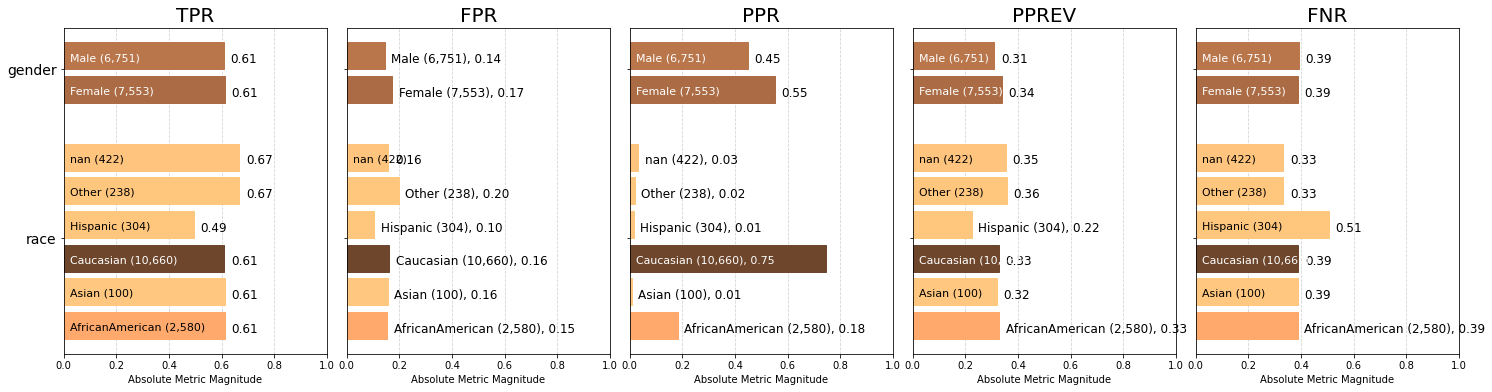

In [141]:
p = aqp.plot_group_metric_all(xtab, metrics=['tpr', 'fpr', 'ppr', 'pprev', 'fnr'], ncols=5)

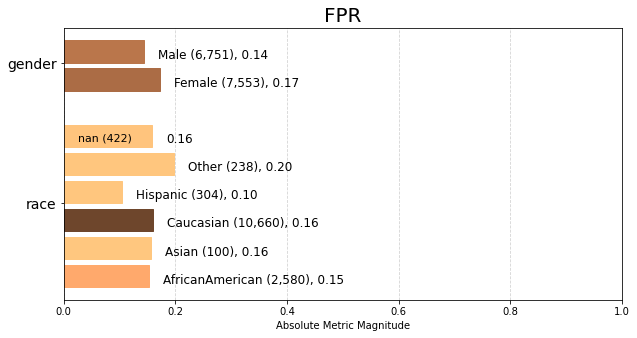

In [142]:
frp = aqp.plot_group_metric(xtab, 'fpr')


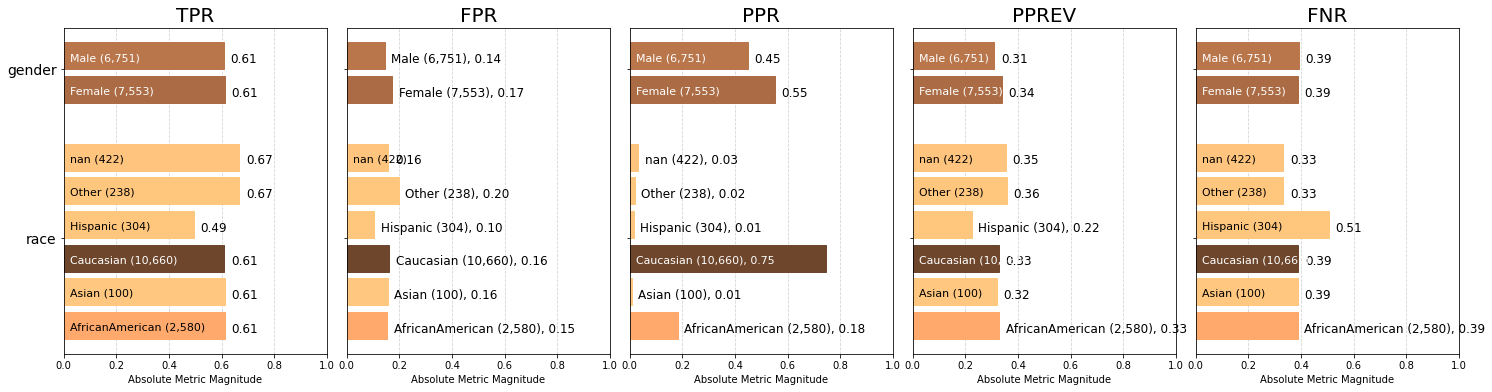

In [143]:

p = aqp.plot_group_metric_all(xtab, metrics=['tpr', 'fpr', 'ppr', 'pprev', 'fnr'], ncols=5)

In [144]:
#fnr = aqp.plot_group_metric(xtab, 'fnr')

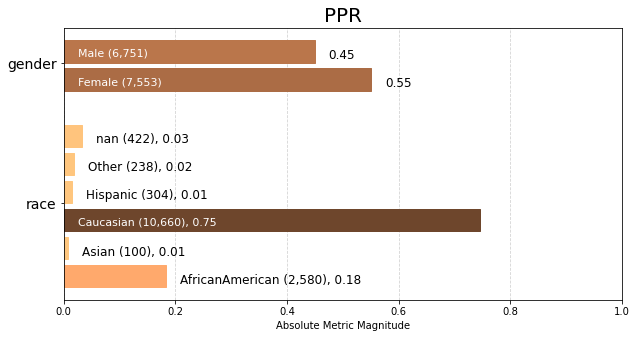

In [145]:
ppr = aqp.plot_group_metric(xtab, 'ppr')

From the visualizations above, we can see that the bias or disparity of the group metrics False Positive Rate (FPR), False Negative Rate (FNR), and Positive Predictive Rate (PPR) across gender is very small or insignificant. However, we can see a significant bias of the group metrics PPR across race. Here, we see that Caucasian has a PPR score of 0.73 followed by African American which has a PPR score of 0.20. This means our model correctly predict most Caucasian which are hospitalized for at least 5 days as the ones who really stay in the hospital for at least 5 days. On the other hand, Hispanic, Asian, and Other race have a PPR of less than or equal to 0.03. This means our model incorectly predict the lenght of hospital stay for these race most of the times.

#### Fairness Analysis - Relative to a Reference Group 

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

#### Reference group fairness plot

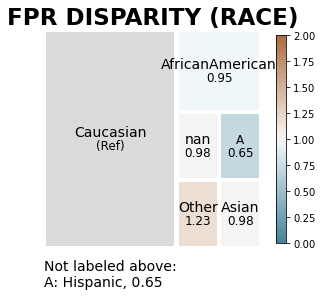

In [146]:
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='race')

African American is 0.95x more likely to be falsely identified than Caucasian. On the other hand, Asian is 0.98x more likely to be falsely identified.



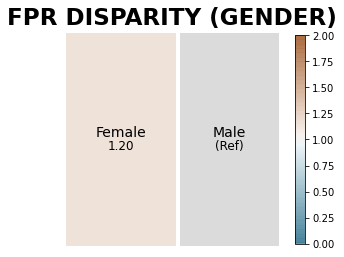

In [147]:
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='gender')

Females are 1.20x more likely than males to be falsely identified as candidates.

Absolute Value Fairness Determination
- Red = False/Not Fair
- Green = True/Fair

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

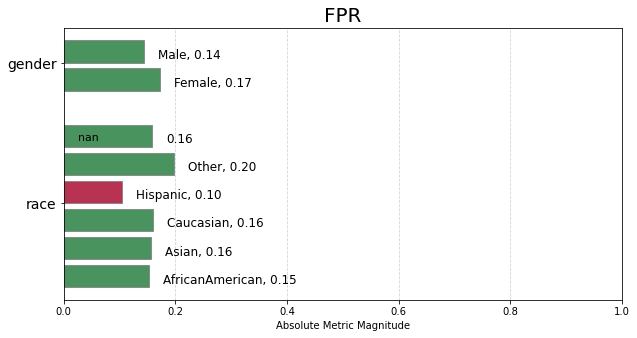

In [148]:

fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

We can see that there appears to be signficant disparity with the Hispanic race being under-represented with a magnitude of 0.10



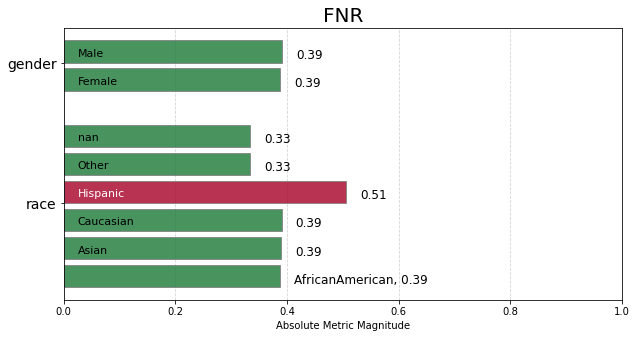

In [151]:
fnr_fairness = aqp.plot_fairness_group(fdf, group_metric='fnr', title=True)

The chart of absolute group metric False Negative Rate (FNR) across gender and race shows that our model is fair to  other groups but with the exceptional to Hispanic which is falsely identified.



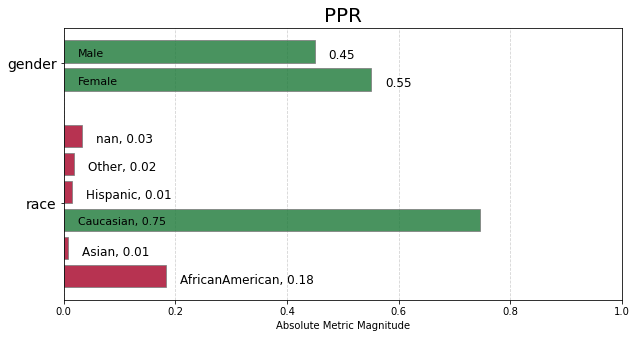

In [150]:
ppr_fairness = aqp.plot_fairness_group(fdf, group_metric='ppr', title=True)

Positive Predictive Rate (PPR) across gender and race displays absolute group metric. The green color indicates that female and Caucasian groups have been determined to be fair.